### Initial exploration 

Notebook for initial exploration of the dataset from `PHM 2010 Challenge`.
The files were downloaded from [Kaggle](https://www.kaggle.com/datasets/rabahba/phm-data-challenge-2010). 

We will use only folders `c1`, `c4` and `c6`, because they have associated wear files.


In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cls
import os
import pyts.image as pyti
import pyts.approximation as pyta

In [4]:
DATAPATH='../../Datasets/PHM2010Challenge'

cutter_c1_sample = pd.read_csv(os.path.join(DATAPATH, 'c1', 'c1', 'c_1_008.csv'), header=None,
                                names=['Fx', 'Fy', 'Fz', 'Vx', 'Vy', 'Vz', 'aerms'])
cutter_c1_wear = pd.read_csv(os.path.join(DATAPATH, 'c1', 'c1_wear.csv'))

print(f"Cutter file shape: {cutter_c1_sample.shape}")
print(f"Wear file shape: {cutter_c1_wear.shape}")
print(f"Number of files in `c1`: {len(os.listdir(os.path.join(DATAPATH, 'c1', 'c1')))}")

Cutter file shape: (218962, 7)
Wear file shape: (315, 4)
Number of files in `c1`: 315


The cutter files consists of a time-series with around 220k rows. The wear file collects the wear after each cut. There are 315 rows, which corresponds to 315 files in the `c1` folder. So, one file in `c1` represents a time-series for one cut.

In [5]:
cutter_c1_sample.head()

,Fx,Fy,Fz,Vx,Vy,Vz,aerms
0,0.272,2.398,0.670,0.155,0.133,0.130,-0.005
1,0.318,2.485,0.804,-0.133,-0.151,-0.155,-0.004
2,0.323,2.501,0.881,0.177,0.149,0.155,-0.005
3,0.338,2.523,0.970,0.166,0.136,0.131,-0.005
4,0.393,2.579,1.091,-0.131,-0.135,-0.144,-0.005


In [6]:
cutter_c1_wear.head()

,cut,flute_1,flute_2,flute_3
0,1,32.317114,48.892617,37.720825
1,2,37.914879,49.570815,37.720825
2,3,43.087910,50.302867,37.720825
3,4,47.859072,51.083652,37.849851
4,5,52.250329,51.908288,38.172665


### Initial plots

For now we I am mostly interested in applying the methodology described in the paper:

Martínez-Arellano, G., Terrazas, G., & Ratchev, S. (2019). Tool wear classification using time series imaging and deep learning. The International Journal of Advanced Manufacturing Technology, 104(9), 3647–3662. https://doi.org/10.1007/s00170-019-04090-6

Therefore, I will use only the columns `Fx`, `Fy` and `Fz` which represent forces in directions, respectively x, y and z.

Since the data was acquired with sample rate 50kHz/channel, we can easily add the `time` columns with time vector.

In [7]:
Ns = cutter_c1_sample.shape[0]
dt = Ns/50e3
cutter_c1_sample['time'] = np.linspace(0, dt, num=Ns)

<AxesSubplot:xlabel='time'>

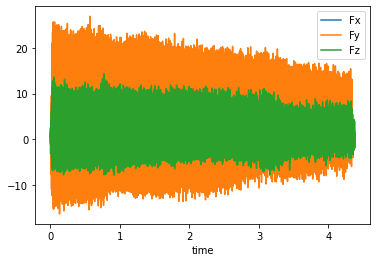

In [8]:
cutter_c1_sample.plot(x='time', y=['Fx', 'Fy', 'Fz']) # A bit too rich

Let's see the first few data points.

<AxesSubplot:xlabel='time'>

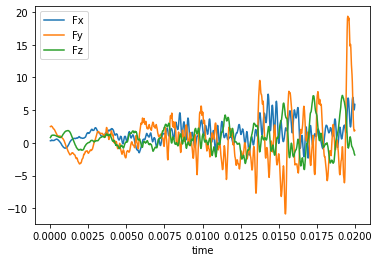

In [9]:
cutter_c1_sample[1:1000].plot(x='time', y=['Fx','Fy','Fz'])

From both plots it seems like `Fy` has highest magnitude among the signals. This is interesting, it probably tells us that the cut was done mostly in the y-axis, which is one of the 'flat' axes along with x. 
Just out of curiosity, it would be interesting to see what is the RMS value of the three signals.

In [10]:
cutter_c1_sample[['Fx', 'Fy', 'Fz']].agg(lambda x: np.sqrt(np.mean(x**2)))

Fx    4.293499
Fy    6.590557
Fz    3.984288
dtype: float64

Indeed the force in `Fy` is the highest even taking into account the RMS. 

Of course it doesn't mean the same happens for all the data files. But without further ado let's introduce the transformations.



### Preprocessing

First step is to preprocess the data such that all forces are between [-1, 1].

In [11]:
rescale = lambda x: ((x - np.max(x)) + (x - np.min(x))) / (np.max(x) - np.min(x))
cutter_c1_rescaled = cutter_c1_sample[['time','Fx', 'Fy', 'Fz']].set_index('time').apply(rescale)

A sanity check.

In [12]:
cutter_c1_rescaled.agg([min, max])

,Fx,Fy,Fz
min,-1.0,-1.0,-1.0
max,1.0,1.0,1.0


<AxesSubplot:xlabel='time'>

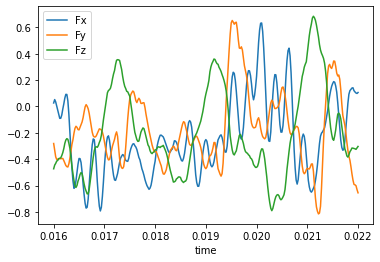

In [13]:
cutter_c1_rescaled.reset_index().loc[800:1100].plot(x='time')

Second step: get the polar coordinates of the signal

$$
\begin{align}
\phi_i &= \arccos(x_i), &\forall_{i = 1, \ldots, n}\\
r_i &=  \frac{t_i}{N},  &\forall_{\{i = 1, \ldots, n | t_i \in \mathbf{N} \} } 
\end{align}
$$

In [14]:
cutter_c1_acos = cutter_c1_rescaled.apply(np.arccos)
cutter_c1_acos["r"] = np.linspace(0, Ns-1, num=Ns)/Ns
cutter_c1_acos.head()

,Fx,Fy,Fz,r
time,,,,
0.00000,2.087567,1.705122,1.807210,0.000000
0.00002,2.081520,1.701055,1.794797,0.000005
0.00004,2.080864,1.700308,1.787680,0.000009
0.00006,2.078897,1.699280,1.779468,0.000014
0.00008,2.071704,1.696664,1.768327,0.000018


In the original paper, we see such transformed data in the form of a polar plot.
As the time increases the data should be wraped around the polar axis. 

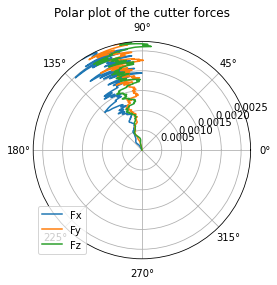

In [15]:
pex = cutter_c1_acos.reset_index().loc[0:600]
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(pex['Fx'], pex['r'], label='Fx')
ax.plot(pex['Fy'], pex['r'], label='Fy')
ax.plot(pex['Fz'], pex['r'], label='Fz')
ax.set_rmax(np.max(pex['r']))
ax.grid(True)
ax.set_title("Polar plot of the cutter forces")
ax.legend(loc='lower left')
plt.show()

We will now compute kind of a Gram matrix, but a specific one, called Gramian Angular Summation Field (GASF).
Since the Gram matrix is of the size $n \times n$, not too exceed the memory limits, we can either take advantage of its symmetricity and create it as a triangular matrix or reduce the size of the initial dataset. We will do the latter, via piecewise aggregation approximation.

In [77]:
# GASF = lambda Phi: np.cos(np.add.outer(np.asarray(Phi), np.asarray(Phi))) # A simple GASF function.
fcutter_xyz = np.asarray(cutter_c1_acos.reset_index()[['Fx','Fy', 'Fz']]).transpose()
paa = pyta.PiecewiseAggregateApproximation(window_size=300)
fcutter_paa = paa.transform(fcutter_xyz)

# Get the number of channels and the number of elements
(nchan, nelem) = fcutter_paa.shape
gasf = pyti.GramianAngularField(image_size=nelem, method='summation')
fcutter_gasf = gasf.fit_transform(fcutter_paa)


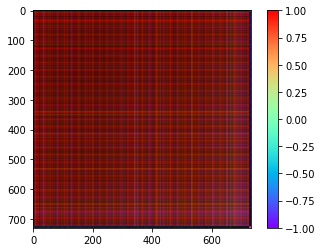

In [87]:
to01 = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
reshaped = np.stack( (to01(fcutter_gasf[0]), to01(fcutter_gasf[1]), to01(fcutter_gasf[2])), axis=2)
fig, ax = plt.subplots()
im = ax.imshow(reshaped, cmap='rainbow', vmin=-1, vmax=1)
fig.colorbar(im)
plt.show()

This is an early file, but anyway this seems strange. Maybe I misred something.
Let's use the same procedure for the last cutting file.

In [181]:
def rescale(x, low=0, high=1):
    return (high - low) * (x - np.min(x)) / (np.max(x) - np.min(x)) + low

def get_gasf(cutter_sample, columns=['Fx','Fy','Fz'], window_size=300):
    cutter_acos = cutter_sample[columns] \
        .apply(lambda x: rescale(x, low=-1, high=1)) \
        .apply(np.arccos)
    cutter_acos = np.asarray(cutter_acos).transpose()
    paa = pyta.PiecewiseAggregateApproximation(window_size=window_size)
    fcutter_paa = paa.transform(cutter_acos)
    nelem = fcutter_paa.shape[1]
    gasf = pyti.GramianAngularField(image_size=nelem, method='summation')
    fcutter_gasf = gasf.transform(fcutter_paa)
    return fcutter_gasf
    
def plot_gasf_image(gasf_data):
    assert gasf_data.shape[0] == 3
    reshaped = np.stack((rescale(gasf_data[0]), rescale(gasf_data[1]), rescale(gasf_data[2])), \
                        axis=2)
    fig, ax = plt.subplots()
    im = ax.imshow(reshaped, cmap='rainbow', vmin=-1, vmax=1)
    fig.colorbar(im)
    plt.show()

def plot_gasf_contour(gasf_data): # No error catching for now
    if len(gasf_data.shape) == 3:
        (_, M, N) = gasf_data.shape
        gasf_data = gasf_data.reshape((M, N))
    else:
        assert(len(gasf_data.shape) == 2 and gasf_data.shape[0]==gasf_data.shape[1])
    # Make a contour plot
    fig, ax = plt.subplots()
    im = ax.contourf(gasf_data,
                cmap='rainbow_r', # Reversed rainbow
                levels=80,
                alpha=0.8,
                vmin=-1, vmax=1,
                origin='upper')
    fig.colorbar(im)
    plt.show()

    

Okay, I get it, the images are produced separately, so it's more like a contour plot rather than an image with RGB layers. Values of the Gram matrix show the intensity of the respective 1-dimensional force.

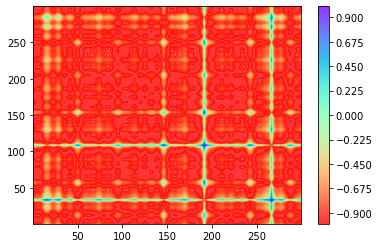

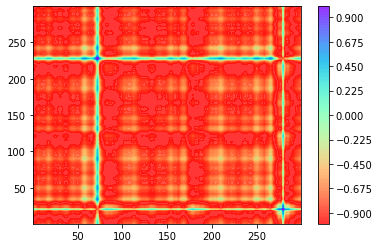

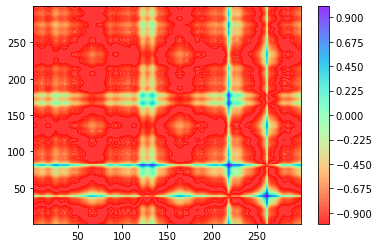

In [182]:
# Load some other file.
cutter_c1_sample_315 = pd.read_csv(os.path.join(DATAPATH, 'c1', 'c1', 'c_1_100.csv'), header=None,
                                names=['Fx', 'Fy', 'Fz', 'Vx', 'Vy', 'Vz', 'aerms'])
# Just a small example 300x300 px without PAA
gasf_c1_315 = get_gasf(cutter_c1_sample_315[800:1100], window_size=1)
for i in range(3):
    plot_gasf_contour(gasf_c1_315[i])


In the paper 'a representative portion of 2,000' measurements was taken from the middle of each the files. 
The methodology of selection is not described so I presume it was done manually. 

To each of these PAA was applied to resize the image to 512x512.

In [196]:
mp = cutter_c1_sample_315.shape[0]//2 
cutter_c1_sample = cutter_c1_sample_315[(mp - 1024):(mp + 1024)]
gasf_c1 = get_gasf(cutter_c1_sample, window_size=4)
print(gasf_c1.shape)

(3, 512, 512)


Ok, this was how the intial preprocessing of the datasets proceeds.
Now, let's discuss the wear files.

## Wear files


As mentioned, with each cutter there is a wear file associated.

In [198]:
cutter_c1_wear.head()

,cut,flute_1,flute_2,flute_3
0,1,32.317114,48.892617,37.720825
1,2,37.914879,49.570815,37.720825
2,3,43.087910,50.302867,37.720825
3,4,47.859072,51.083652,37.849851
4,5,52.250329,51.908288,38.172665


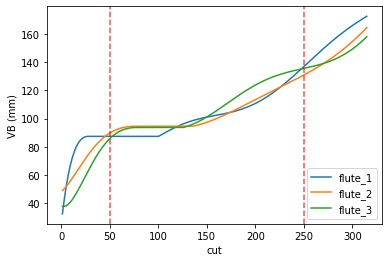

In [212]:
cutter_c1_wear.plot(x='cut')
for xcord in [50, 250]:
    plt.axvline(x=xcord, c='red', alpha=0.7, linestyle='--')
plt.ylabel("VB (mm)")
plt.show()